In [1]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import unicodedata
import string
import numpy as np
import re
import matplotlib.pyplot as plt
#from google.colab import drive

In [3]:
def Convert(string):
    li = list(string.split(" "))
    return li

In [4]:
def listToString(s): 
    
    # initialize an empty string
    str1 = ' ' 
    
    # return string  
    return (str1.join(s))

In [5]:
keras = tf.keras
print(tf.__version__)

2.4.1


In [6]:
!wget https://www.manythings.org/anki/fra-eng.zip
!unzip  fra-eng.zip

--2021-03-28 04:19:35--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org... 172.67.173.198, 104.21.55.222, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6281268 (6.0M) [application/zip]
Saving to: ‘fra-eng.zip.4’

fra-eng.zip.4       100%[===================>]   5.99M  1.22MB/s    in 5.6s    

2021-03-28 04:19:42 (1.07 MB/s) - ‘fra-eng.zip.4’ saved [6281268/6281268]

Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
SOS_token = 0
EOS_token = 1

In [8]:
class Lang(object):
    def __init__(self, name):
        self.name = name
        self.word2int = {}
        self.word2count = {}
        self.int2word = {0 : "SOS", 1 : "EOS"}
        self.n_words = 2
        
    def addWord(self, word):
        if word not in self.word2int:
            self.word2int[word] = self.n_words
            self.word2count[word] = 1
            self.int2word[self.n_words] = word
            self.n_words += 1
            
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

In [9]:
def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) \
                   if unicodedata.category(c) != "Mn")

In [10]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    
    s = re.sub(r"([!.?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z?.!]+", " ", s)
    return s

In [11]:
def load_dataset():
    with open("fra.txt",'r') as f:
        lines = f.readlines()
    
    pairs = [[normalizeString(pair) for pair in 
              line.strip().split('\t')] for line in lines]
    return pairs

In [12]:
pairs = load_dataset()

In [13]:
MAX_LENGTH = 10
def sentencetoIndexes(sentence, lang):
    indexes = [lang.word2int[word] for word in sentence.split()]
    indexes.append(EOS_token)
    return indexes

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

In [61]:
pairs[0][2]

'cc by . france attribution tatoeba .org cm wittydev '

In [15]:
def build_lang(lang1, lang2, max_length=10):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    input_seq = []
    output_seq = []
    
    for pair in pairs:
        input_lang.addSentence(pair[1])
        output_lang.addSentence(pair[0])
    for pair in pairs:
        input_seq.append(sentencetoIndexes(pair[1], input_lang))
        output_seq.append(sentencetoIndexes(pair[0], output_lang))
    return keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=max_length, padding='post',
                                                      truncating='post'), \
keras.preprocessing.sequence.pad_sequences(output_seq, padding='post', truncating='post'), input_lang, output_lang

In [16]:
input_tensor, output_tensor, input_lang, output_lang = build_lang('fr', 'en')

In [17]:
input_lang.name

'fr'

In [18]:
BATCH_SIZE = 128
BUFFER_SIZE = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [19]:
class Encoder(keras.models.Model):
    def __init__(self, vocab_size, num_hidden=256, num_embedding=256, batch_size=128):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.num_hidden = num_hidden
        self.num_embedding = num_embedding
        self.embedding = keras.layers.Embedding(vocab_size, num_embedding)
        self.gru = keras.layers.GRU(num_hidden, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                   return_state=True)
        
    def call(self, x, hidden):
        embedded = self.embedding(x)
        rnn_out, hidden = self.gru(embedded, initial_state=hidden)
        return rnn_out, hidden
    def init_hidden(self):
        return tf.zeros(shape=(self.batch_size, self.num_hidden))

In [20]:
inputs, outputs = next(iter(dataset))
hidden = tf.zeros((128, 256))

In [21]:
encoder = Encoder(input_lang.n_words)

In [22]:
e_outputs, e_hidden = encoder(inputs, hidden)

In [23]:
e_hidden

<tf.Tensor: shape=(128, 256), dtype=float32, numpy=
array([[ 0.00120121,  0.00040375,  0.00781761, ...,  0.01604841,
         0.00540511, -0.02816603],
       [ 0.00729156,  0.00092345,  0.01161359, ...,  0.0379127 ,
         0.00293805, -0.0326785 ],
       [ 0.00635105,  0.00290918,  0.01400031, ...,  0.0285332 ,
         0.00682477, -0.03156468],
       ...,
       [ 0.00396224,  0.00047232,  0.01347383, ...,  0.03284305,
         0.00264421, -0.03273234],
       [ 0.00484819,  0.00595837,  0.00248137, ..., -0.00217395,
         0.01141609, -0.01265813],
       [ 0.00077437, -0.00138516,  0.00955012, ...,  0.01716059,
         0.00580018, -0.0205926 ]], dtype=float32)>

In [24]:
class BahdanauAttention(keras.models.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
    
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, encoder_out, hidden):
        #shape of encoder_out : batch_size, seq_length, hidden_dim 
        #shape of encoder_hidden : batch_size, hidden_dim 
        
        hidden = tf.expand_dims(hidden, axis=1) #out:
        
        score = self.V(tf.nn.tanh(self.W1(encoder_out) + \
                                  self.W2(hidden))) 
        
        attn_weights = tf.nn.softmax(score, axis=1)
        
        context =  attn_weights * encoder_out 
        context = tf.reduce_sum(context, axis=1)
        return context, attn_weights
        

In [25]:
attn = BahdanauAttention(256)

In [26]:
context, attn_weights = attn(e_outputs, e_hidden)

In [27]:
attn_weights.shape

TensorShape([128, 10, 1])

In [28]:
class Decoder(keras.models.Model):
    def __init__(self, vocab_size, dec_dim=256, embedding_dim=256):
        super(Decoder, self).__init__()
        
        self.attn = BahdanauAttention(dec_dim)
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(dec_dim, recurrent_initializer='glorot_uniform',
                                   return_sequences=True, return_state=True)
        self.fc = keras.layers.Dense(vocab_size)
        
    def call(self, x, enc_hidden, enc_out):
        x = self.embedding(x)
        context, attn_weights = self.attn(enc_out, enc_hidden)
        x = tf.concat((tf.expand_dims(context, 1), x), -1)
        r_out, hidden = self.gru(x, initial_state=enc_hidden)
        out = tf.reshape(r_out,shape=(-1, r_out.shape[2]))
        return self.fc(out), hidden, attn_weights

In [29]:
decoder = Decoder(output_lang.n_words)

In [30]:
input_tensor, output_tensor = next(iter(dataset))

In [31]:
x = np.expand_dims(output_tensor[:,1], -1)

In [32]:
def loss_fn(real, pred):
    criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    _loss = criterion(real, pred)
    mask = tf.cast(mask, dtype=_loss.dtype)
    _loss *= mask
    return tf.reduce_mean(_loss)

In [33]:
optimizer = tf.optimizers.Adam()

In [34]:
def train_step(input_tensor, target_tensor, enc_hidden):
    loss = 0.0
    with tf.GradientTape() as tape:
    
        batch_size = input_tensor.shape[0]
        enc_output, enc_hidden = encoder(input_tensor, enc_hidden)

        SOS_tensor = np.array([SOS_token])
        dec_input = tf.squeeze(tf.expand_dims([SOS_tensor]*batch_size, 1), -1)
        dec_hidden = enc_hidden

        for tx in range(target_tensor.shape[1]-1):
          
            dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                            enc_output)
            loss += loss_fn(target_tensor[:, tx], dec_out)
            dec_input = tf.expand_dims(target_tensor[:, tx], 1)

    batch_loss = loss / target_tensor.shape[1]
    t_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, t_variables)
    optimizer.apply_gradients(zip(gradients, t_variables))
    return batch_loss
    

In [35]:
hidden = tf.zeros(shape=(128, 256))
loss = train_step(input_tensor, output_tensor, hidden)
print(loss)

tf.Tensor(6.6888223, shape=(), dtype=float32)


In [44]:
def checkpoint(model, name=None):
    if name is not None:
        model.save_weights('{}.h5'.format(name))
    else:
        raise NotImplementedError

In [52]:
EPOCHS = 10
log_every = 5
steps_per_epoch = len(pairs) // BATCH_SIZE
loss_list = []

for e in range(1, EPOCHS):
    
    total_loss = 0.0
    enc_hidden = encoder.init_hidden()
    
    for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input_tensor, target_tensor, hidden)
        total_loss += batch_loss
        
        if idx % log_every == 0:
            loss_list.append(batch_loss)
            print("Epochs: {} batch_loss: {:.4f}".format(e, batch_loss))
            checkpoint(encoder, 'encoder5')
            checkpoint(decoder, 'decoder5')
            
    if e % 2 == 0:
        print("Epochs: {}/{} total_loss: {:.4f}".format(
        e, EPOCHS, total_loss / steps_per_epoch))

Epochs: 1 batch_loss: 6.7541
Epochs: 1 batch_loss: 6.2169
Epochs: 1 batch_loss: 4.4412
Epochs: 1 batch_loss: 3.9101
Epochs: 1 batch_loss: 3.8257
Epochs: 1 batch_loss: 3.9369
Epochs: 1 batch_loss: 3.8754
Epochs: 1 batch_loss: 3.8226
Epochs: 1 batch_loss: 3.7262
Epochs: 1 batch_loss: 3.8326
Epochs: 1 batch_loss: 3.6739
Epochs: 1 batch_loss: 3.7136
Epochs: 1 batch_loss: 3.7685
Epochs: 1 batch_loss: 3.7749
Epochs: 1 batch_loss: 3.7368
Epochs: 1 batch_loss: 3.6167
Epochs: 1 batch_loss: 3.6063
Epochs: 1 batch_loss: 3.7400
Epochs: 1 batch_loss: 3.5559
Epochs: 1 batch_loss: 3.5124
Epochs: 1 batch_loss: 3.6554
Epochs: 1 batch_loss: 3.5912
Epochs: 1 batch_loss: 3.4930
Epochs: 1 batch_loss: 3.5730
Epochs: 1 batch_loss: 3.6357
Epochs: 1 batch_loss: 3.4722
Epochs: 1 batch_loss: 3.5131
Epochs: 1 batch_loss: 3.4824
Epochs: 1 batch_loss: 3.4212
Epochs: 1 batch_loss: 3.3980
Epochs: 1 batch_loss: 3.4984
Epochs: 1 batch_loss: 3.5021
Epochs: 1 batch_loss: 3.4398
Epochs: 1 batch_loss: 3.4936
Epochs: 1 batc

In [53]:
def translate(sentence, max_length=10):
    result = ''
    attention_plot = np.zeros((10,10))
    sentence = normalizeString(sentence)
    sentence = sentencetoIndexes(sentence, input_lang)
    sentence = keras.preprocessing.sequence.pad_sequences([sentence],padding='post',
                                                      maxlen=max_length, truncating='post')
    
    encoder_hidden = hidden = [tf.zeros((1, 256))]
    
    enc_out, enc_hidden = encoder(sentence, encoder_hidden)
    
    dec_hidden = enc_hidden
    SOS_tensor = np.array([SOS_token])
    dec_input = tf.squeeze(tf.expand_dims([SOS_tensor], 1), -1)
    
    for tx in range(max_length):
        dec_out, dec_hidden, attn_weights = decoder(dec_input,
                                                   dec_hidden, enc_out)
        attn_weights = tf.reshape(attn_weights, (-1, ))
        attention_plot[tx] = attn_weights.numpy()
        pred = tf.argmax(dec_out, axis=1).numpy()
        result += output_lang.int2word[pred[0]] + " "
        if output_lang.int2word[pred[0]] == "EOS":
            break
        dec_input = tf.expand_dims(pred, axis=1)
    return result, attention_plot

In [54]:
sentence = "j'ai besoin de quelqu'un pour m'aider ?"
pred, attn_weights = translate(sentence)
print(pred)

do i need someone to help me ? EOS 


In [55]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = normalizeString(listToString(sentence))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + Convert(sentence), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [56]:
from matplotlib import ticker

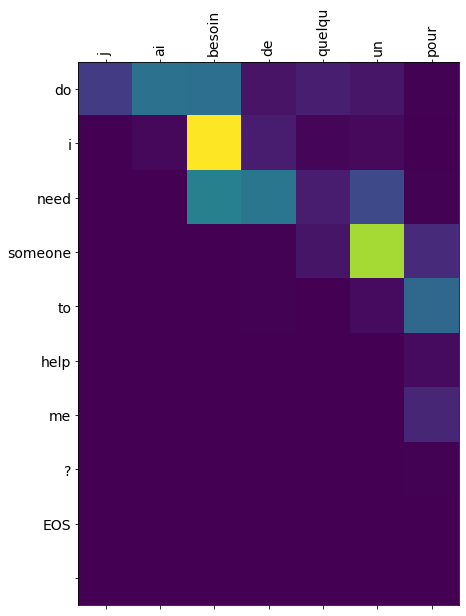

In [57]:
attn_weights = attn_weights[:len(pred.split(' ')), :len(sentence.split(' '))]
plot_attention(attn_weights, sentence.split(), pred.split())

In [51]:
model.load_weights('model.h5')

NameError: name 'model' is not defined

In [ ]:
encoder=models.load_weights('encoder.h5')
decoder=load_model('decoder.h5')

In [ ]:
from keras import models

In [ ]:
tf.keras.models.load_weights(encoder.h5, by_name=False, skip_mismatch=False, options=None)

In [60]:
print(pairs[0][0])

go .
